In [1]:
#importing packages 
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score

In [2]:
#reading data
df_train=pd.read_csv("application_train.csv")
df_test=pd.read_csv("application_test.csv")
df_bureau=pd.read_csv("bureau.csv")

In [3]:
#majority class classifier 
target_counts=df_train['TARGET'].value_counts()
target_percent=target_counts/target_counts.sum()*100
print("percentage of rows having target as 0 (i.e. customers who do not default): ",target_percent[0])
print("percentage of rows having target as 1 (i.e. customers who default):",target_percent[1])

percentage of rows having target as 0 (i.e. customers who do not default):  91.92711805431351
percentage of rows having target as 1 (i.e. customers who default): 8.072881945686495


In [4]:
#Dropping columns with lots of missing values ( 66%)

threshold = 66  # Setting the threshold percentage
# Calculating the total and percentage of missing values for each column
total = df_train.isnull().sum()
percentage = (df_train.isnull().sum() / df_train.isnull().count()) * 100
# Creating a mask to identify columns with more than the threshold percentage of missing values
mask = percentage > threshold
# Selecting the columns to remove
columns_to_remove = total[mask].index
# Removing the columns from the DataFrame
df_train = df_train.drop(columns=columns_to_remove)

In [5]:
#removing XNA gender column
df_train = df_train[df_train['CODE_GENDER'] != 'XNA']
df_train['CODE_GENDER'].value_counts()

F    202448
M    105059
Name: CODE_GENDER, dtype: int64

In [6]:
#dropping on test dataset 

threshold = 65  # Setting the threshold percentage

# Calculating the total and percentage of missing values for each column
total = df_test.isnull().sum()
percentage = (df_test.isnull().sum() / df_test.isnull().count()) * 100

# Creating a mask to identify columns with more than the threshold percentage of missing values
mask = percentage > threshold

# Select the columns to remove, except for 'OWN_CAR_AVG'
columns_to_remove = total[mask].index.tolist()
columns_to_remove.remove('OWN_CAR_AGE')

# Remove the columns from the DataFrame
df_test = df_test.drop(columns=columns_to_remove)

# Display the modified DataFrame
df_test.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_test = df_test[df_test['CODE_GENDER'] != 'XNA']
df_test['CODE_GENDER'].value_counts()

F    32678
M    16066
Name: CODE_GENDER, dtype: int64

In [8]:
#test
# List of categorical columns with missing values
categorical_columns = ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

# Replace missing values with "Missing" in the categorical columns
for column in categorical_columns:
    df_train[column] = df_train[column].fillna("Missing")

In [9]:
#train
# List of categorical columns with missing values
categorical_columns = ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

# Replace missing values with "Missing" in the categorical columns
for column in categorical_columns:
    df_test[column] = df_test[column].fillna("Missing")

In [10]:
#dropping unecessary columns 
df_train.drop(df_train[df_train['NAME_INCOME_TYPE'] == 'Maternity leave'].index, inplace=True)
df_train.drop(df_train[df_train['NAME_FAMILY_STATUS'] == 'Unknown'].index, inplace=True)

In [11]:
#Label encoding 
#Label Encoding on train 
from sklearn.preprocessing import LabelEncoder

# Define the dataframe 'df' containing the columns

# Define the columns to label encode based on values <= 2
columns_to_encode = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

# Label encode the selected columns
label_encoder = LabelEncoder()

for column in columns_to_encode:
    if df_train[column].nunique() <= 2:  # Check if number of unique values is less than or equal to 2
        df_train[column] = label_encoder.fit_transform(df_train[column])
df_train[['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY
0,0,1,0,1
1,0,0,0,0
2,1,1,1,1
3,0,0,0,1
4,0,1,0,1


In [12]:
# One Hot Encoding
categorical_columns =['NAME_TYPE_SUITE',
                   'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                   'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE',
                   'WALLSMATERIAL_MODE','NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


# Perform one-hot encoding using get_dummies()
df_encoded_train = pd.get_dummies(df_train, columns=categorical_columns)

# Print the encoded DataFrame
df_encoded_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Missing,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Missing,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,1,0,0,1,0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,1,0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,1,0,0,0,0,0,0,1,0,0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,1,0,0,0,0,0,0,1,0,0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,1,0,0,0,0,0,0,1,0,0


In [13]:
#Label Encoding on test
from sklearn.preprocessing import LabelEncoder

# Define the dataframe 'df' containing the columns

# Define the columns to label encode based on values <= 2
columns_to_encode = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']

# Label encode the selected columns
label_encoder = LabelEncoder()

for column in columns_to_encode:
    if df_test[column].nunique() <=2:  # Check if number of unique values is less than or equal to 2
        df_test[column] = label_encoder.fit_transform(df_test[column])
df_test.head(5)


# Define a list of categorical columns to be one-hot encoded
categorical_columns =['NAME_TYPE_SUITE',
                   'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                   'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE',
                   'WALLSMATERIAL_MODE','NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


# Perform one-hot encoding using get_dummies()
df_encoded_test = pd.get_dummies(df_test, columns=categorical_columns)

# Print the encoded DataFrame
df_encoded_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Missing,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Missing,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0,1,0,0,1,0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,1,0,0,0,0,0,0,1,0,0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,1,0,0,0,0,0,0,1,0,0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,1,0,0,0,1,0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,1,0,0,0,0,0,0,1,0,0


In [14]:
#We encountered that one hot encoding has resulted in duplicate columns in both the test and train data. We are dropping duplicates while retaining the original columns as shown below.
# Assuming df_encoded_train is the DataFrame

# Identify the duplicate columns
duplicate_columns_train = df_encoded_train.columns[df_encoded_train.columns.duplicated()]
duplicate_columns_test = df_encoded_test.columns[df_encoded_test.columns.duplicated()]
# Print the duplicate column names
print("The number of duplicates in the train data are:",len(duplicate_columns_train))
print("The number of duplicates in the test data are:",len(duplicate_columns_test))

The number of duplicates in the train data are: 39
The number of duplicates in the test data are: 39


In [15]:
# Assuming df_encoded_train is the DataFrame

# Identify the duplicate columns
duplicate_columns = df_encoded_train.columns[df_encoded_train.columns.duplicated()]

# Drop duplicate columns while keeping one
df_encoded_train_unique = df_encoded_train.loc[:, ~df_encoded_train.columns.duplicated()]

# Print the DataFrame with duplicate columns dropped
df_encoded_train_unique.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Missing,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Missing,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,1,0,0,1,0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,1,0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,1,0,0,0,0,0,0,1,0,0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,1,0,0,0,0,0,0,1,0,0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,1,0,0,0,0,0,0,1,0,0


In [16]:
# Assuming df_encoded_test is the DataFrame

# Identify the duplicate columns
duplicate_columns = df_encoded_test.columns[df_encoded_test.columns.duplicated()]

# Drop duplicate columns while keeping one
df_encoded_test_unique = df_encoded_test.loc[:, ~df_encoded_test.columns.duplicated()]

# Print the DataFrame with duplicate columns dropped
df_encoded_test_unique.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Missing,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Missing,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0,1,0,0,1,0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,1,0,0,0,0,0,0,1,0,0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,1,0,0,0,0,0,0,1,0,0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,1,0,0,0,1,0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,1,0,0,0,0,0,0,1,0,0


In [17]:
#Binning car age values 
def process_own_car_age(df):
    df_encoded_train_unique['OWN_CAR_AGE'].fillna(0, inplace=True)
    df_encoded_train_unique['OWN_CAR_AGE'] = df_encoded_train_unique['OWN_CAR_AGE'].apply(lambda x: 0 if x == 0 else (1 if 10 <= x <= 20 else (2 if 21 <= x <= 30 else 3)))
    return df_encoded_train
process_own_car_age(df_encoded_train_unique)
df_encoded_train_unique['OWN_CAR_AGE'].value_counts()

0    205055
3     56297
1     38026
2      8122
Name: OWN_CAR_AGE, dtype: int64

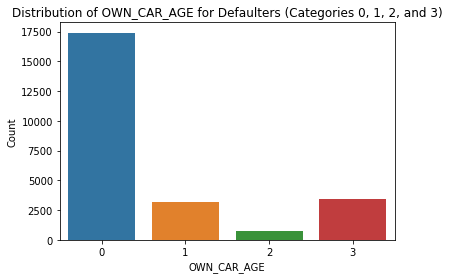

In [18]:
# Filter the DataFrame to include only defaulters
defaulters = df_encoded_train_unique[df_encoded_train_unique['TARGET'] == 1]

# Create a count plot of the four categories
sns.countplot(data=defaulters, x='OWN_CAR_AGE')

plt.title('Distribution of OWN_CAR_AGE for Defaulters (Categories 0, 1, 2, and 3)')
plt.xlabel('OWN_CAR_AGE')
plt.ylabel('Count')

plt.show()

In [19]:
#Replacing this value with the mean of the column and converting the negative values to positive using absolute method
df_encoded_train_unique['DAYS_EMPLOYED']=df_encoded_train_unique['DAYS_EMPLOYED'].abs()

mean_value = df_encoded_train_unique.loc[df_encoded_train_unique['DAYS_EMPLOYED'] != 365243, 'DAYS_EMPLOYED'].mean()
df_encoded_train_unique['DAYS_EMPLOYED'].replace(365243, mean_value, inplace=True)
df_encoded_train_unique['DAYS_EMPLOYED'].describe()

count    307500.000000
mean       2384.150631
std        2117.364389
min           0.000000
25%         933.000000
50%        2219.000000
75%        2760.000000
max       17912.000000
Name: DAYS_EMPLOYED, dtype: float64

In [20]:
#DAYS_BIRTH, DAYS_REGISTRATION, DAYS_ID_PUBLISH, DAYS_EMPLOYED have negative values which are converted to positive using absolute method.

df_encoded_train_unique['DAYS_BIRTH']=df_encoded_train_unique['DAYS_BIRTH'].abs()
df_encoded_train_unique['DAYS_REGISTRATION']=df_encoded_train_unique['DAYS_REGISTRATION'].abs()
df_encoded_train_unique['DAYS_ID_PUBLISH']=df_encoded_train_unique['DAYS_ID_PUBLISH'].abs()
df_encoded_train_unique['DAYS_EMPLOYED']=df_encoded_train_unique['DAYS_EMPLOYED'].abs()

In [21]:
#Binning car age values on test dataset
def process_own_car_age(df):
    df_encoded_test_unique['OWN_CAR_AGE'].fillna(0, inplace=True)
    df_encoded_test_unique['OWN_CAR_AGE'] = df_encoded_test_unique['OWN_CAR_AGE'].apply(lambda x: 0 if x == 0 else (1 if 10 <= x <= 20 else (2 if 21 <= x <= 30 else 3)))
    return df_encoded_test_unique
process_own_car_age(df_encoded_test_unique)
df_encoded_test_unique['OWN_CAR_AGE'].value_counts()

0    32430
3     9160
1     5939
2     1215
Name: OWN_CAR_AGE, dtype: int64

In [22]:
#Replacing this value with the mean of the column and converting the negative values to positive using absolute method
df_encoded_test_unique['DAYS_EMPLOYED']=df_encoded_test_unique['DAYS_EMPLOYED'].abs()

mean_value = df_encoded_test_unique.loc[df_encoded_test_unique['DAYS_EMPLOYED'] != 365243, 'DAYS_EMPLOYED'].mean()
df_encoded_test_unique['DAYS_EMPLOYED'].replace(365243, mean_value, inplace=True)
df_encoded_test_unique['DAYS_EMPLOYED'].describe()

count    48744.000000
mean      2476.738941
std       2076.829996
min          1.000000
25%       1048.000000
50%       2432.000000
75%       2910.000000
max      17463.000000
Name: DAYS_EMPLOYED, dtype: float64

In [23]:
#converting negative values on the test dataset
df_encoded_test_unique['DAYS_BIRTH']=df_encoded_test_unique['DAYS_BIRTH'].abs()
df_encoded_test_unique['DAYS_REGISTRATION']=df_encoded_test_unique['DAYS_REGISTRATION'].abs()
df_encoded_test_unique['DAYS_ID_PUBLISH']=df_encoded_test_unique['DAYS_ID_PUBLISH'].abs()
df_encoded_test_unique['DAYS_EMPLOYED']=df_encoded_test_unique['DAYS_EMPLOYED'].abs()

In [24]:
#Feature Engineering on train data
df_encoded_train_unique['APPS_EXT_SOURCE_MEAN'] = df_encoded_train_unique[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
df_encoded_train_unique['APPS_EXT_SOURCE_STD'] = df_encoded_train_unique[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df_encoded_train_unique['APPS_EXT_SOURCE_STD'] = df_encoded_train_unique['APPS_EXT_SOURCE_STD'].fillna(df_encoded_train_unique['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 
df_encoded_train_unique['APPS_ANNUITY_CREDIT_RATIO'] = df_encoded_train_unique['AMT_ANNUITY']/df_encoded_train_unique['AMT_CREDIT']
df_encoded_train_unique['APPS_GOODS_CREDIT_RATIO'] = df_encoded_train_unique['AMT_GOODS_PRICE']/df_encoded_train_unique['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 
df_encoded_train_unique['APPS_ANNUITY_INCOME_RATIO'] =df_encoded_train_unique['AMT_ANNUITY']/df_encoded_train_unique['AMT_INCOME_TOTAL']
df_encoded_train_unique['APPS_CREDIT_INCOME_RATIO'] = df_encoded_train_unique['AMT_CREDIT']/df_encoded_train_unique['AMT_INCOME_TOTAL']
df_encoded_train_unique['APPS_GOODS_INCOME_RATIO'] = df_encoded_train_unique['AMT_GOODS_PRICE']/df_encoded_train_unique['AMT_INCOME_TOTAL']
df_encoded_train_unique['APPS_CNT_FAM_INCOME_RATIO'] = df_encoded_train_unique['AMT_INCOME_TOTAL']/df_encoded_train_unique['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 
df_encoded_train_unique['APPS_EMPLOYED_BIRTH_RATIO'] = df_encoded_train_unique['DAYS_EMPLOYED']/df_encoded_train_unique['DAYS_BIRTH']
df_encoded_train_unique['APPS_INCOME_EMPLOYED_RATIO'] = df_encoded_train_unique['AMT_INCOME_TOTAL']/df_encoded_train_unique['DAYS_EMPLOYED']
df_encoded_train_unique['APPS_INCOME_BIRTH_RATIO'] = df_encoded_train_unique['AMT_INCOME_TOTAL']/df_encoded_train_unique['DAYS_BIRTH']
df_encoded_train_unique['APPS_CAR_BIRTH_RATIO'] = df_encoded_train_unique['OWN_CAR_AGE'] / df_encoded_train_unique['DAYS_BIRTH']
df_encoded_train_unique['APPS_CAR_EMPLOYED_RATIO'] = df_encoded_train_unique['OWN_CAR_AGE'] /df_encoded_train_unique['DAYS_EMPLOYED']

In [25]:
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df_encoded_train_unique['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df_encoded_train_unique.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df_encoded_train_unique.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize=(12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df_encoded_train_unique.loc[df['TARGET'] == 0, var_name], label='Not default')
    sns.kdeplot(df_encoded_train_unique.loc[df['TARGET'] == 1, var_name], label='Default')
    
    # Label the plot
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution' % var_name)
    plt.legend()
    
    # Print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid = %0.4f' % avg_repaid)
    

The correlation between APPS_ANNUITY_CREDIT_RATIO and the TARGET is 0.0127
Median value for loan that was not repaid = 0.0500
Median value for loan that was repaid = 0.0500


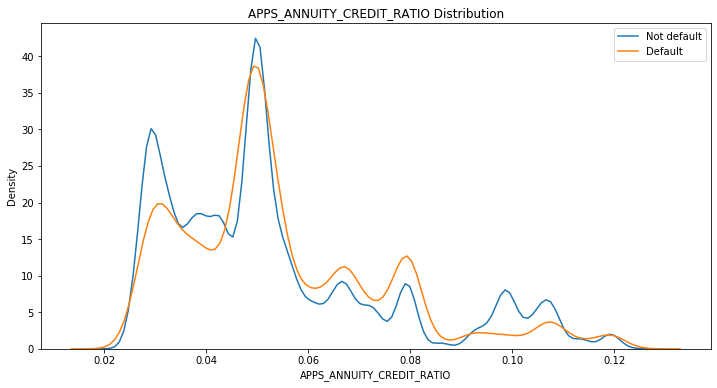

In [26]:
kde_target('APPS_ANNUITY_CREDIT_RATIO', df_encoded_train_unique)

The correlation between APPS_CREDIT_INCOME_RATIO and the TARGET is -0.0078
Median value for loan that was not repaid = 3.2529
Median value for loan that was repaid = 3.2667


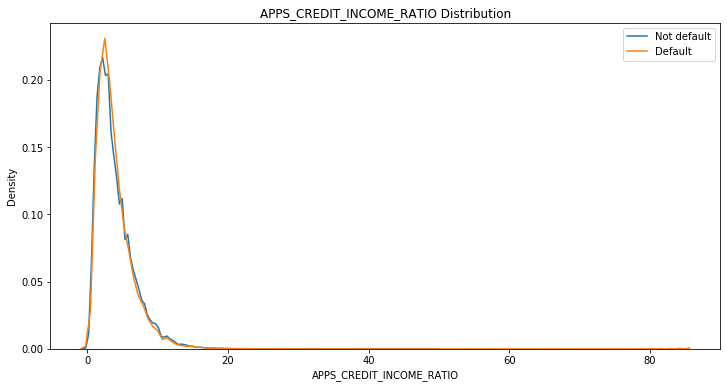

In [27]:
kde_target('APPS_CREDIT_INCOME_RATIO', df_encoded_train_unique)

The correlation between APPS_EMPLOYED_BIRTH_RATIO and the TARGET is -0.0553
Median value for loan that was not repaid = 0.1030
Median value for loan that was repaid = 0.1115


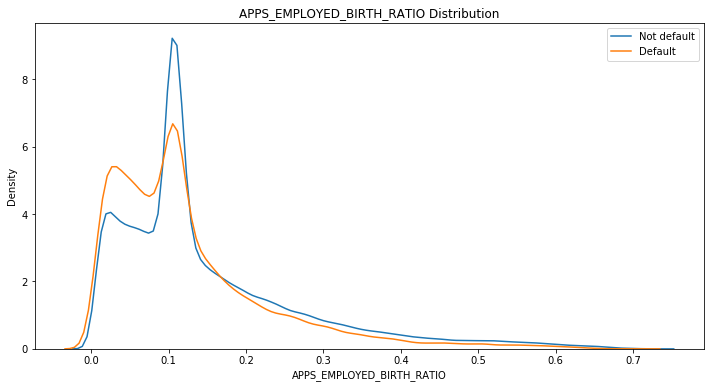

In [28]:
kde_target('APPS_EMPLOYED_BIRTH_RATIO', df_encoded_train_unique)

In [29]:
#Feature engineering on the test dataset

df_encoded_test_unique['APPS_EXT_SOURCE_MEAN'] = df_encoded_test_unique[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
df_encoded_test_unique['APPS_EXT_SOURCE_STD'] = df_encoded_test_unique[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df_encoded_test_unique['APPS_EXT_SOURCE_STD'] = df_encoded_test_unique['APPS_EXT_SOURCE_STD'].fillna(df_encoded_test_unique['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 
df_encoded_test_unique['APPS_ANNUITY_CREDIT_RATIO'] = df_encoded_test_unique['AMT_ANNUITY']/df_encoded_test_unique['AMT_CREDIT']
df_encoded_test_unique['APPS_GOODS_CREDIT_RATIO'] = df_encoded_test_unique['AMT_GOODS_PRICE']/df_encoded_test_unique['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 
df_encoded_test_unique['APPS_ANNUITY_INCOME_RATIO'] =df_encoded_test_unique['AMT_ANNUITY']/df_encoded_test_unique['AMT_INCOME_TOTAL']
df_encoded_test_unique['APPS_CREDIT_INCOME_RATIO'] = df_encoded_test_unique['AMT_CREDIT']/df_encoded_test_unique['AMT_INCOME_TOTAL']
df_encoded_test_unique['APPS_GOODS_INCOME_RATIO'] = df_encoded_test_unique['AMT_GOODS_PRICE']/df_encoded_test_unique['AMT_INCOME_TOTAL']
df_encoded_test_unique['APPS_CNT_FAM_INCOME_RATIO'] = df_encoded_test_unique['AMT_INCOME_TOTAL']/df_encoded_test_unique['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 
df_encoded_test_unique['APPS_EMPLOYED_BIRTH_RATIO'] = df_encoded_test_unique['DAYS_EMPLOYED']/df_encoded_test_unique['DAYS_BIRTH']
df_encoded_test_unique['APPS_INCOME_EMPLOYED_RATIO'] = df_encoded_test_unique['AMT_INCOME_TOTAL']/df_encoded_test_unique['DAYS_EMPLOYED']
df_encoded_test_unique['APPS_INCOME_BIRTH_RATIO'] = df_encoded_test_unique['AMT_INCOME_TOTAL']/df_encoded_test_unique['DAYS_BIRTH']
df_encoded_test_unique['APPS_CAR_BIRTH_RATIO'] = df_encoded_test_unique['OWN_CAR_AGE'] / df_encoded_test_unique['DAYS_BIRTH']
df_encoded_test_unique['APPS_CAR_EMPLOYED_RATIO'] = df_encoded_test_unique['OWN_CAR_AGE'] /df_encoded_test_unique['DAYS_EMPLOYED']

In [30]:
#Feature engineering on bureau 

df_bureau['BUREAU_ENDDATE_FACT_DIFF'] = df_bureau['DAYS_CREDIT_ENDDATE'] - df_bureau['DAYS_ENDDATE_FACT']
df_bureau['BUREAU_CREDIT_FACT_DIFF'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_ENDDATE_FACT']
df_bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_CREDIT_ENDDATE']
  

df_bureau['BUREAU_CREDIT_DEBT_RATIO']=df_bureau['AMT_CREDIT_SUM_DEBT']/df_bureau['AMT_CREDIT_SUM']

df_bureau['BUREAU_CREDIT_DEBT_DIFF'] = df_bureau['AMT_CREDIT_SUM_DEBT'] -df_bureau['AMT_CREDIT_SUM']
    

df_bureau['BUREAU_IS_DPD'] = df_bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
df_bureau['BUREAU_IS_DPD_OVER120'] = df_bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)

In [31]:
  bureau_agg_dict = {
  'SK_ID_BUREAU':['count'],
  'DAYS_CREDIT':['min', 'max', 'mean'],
  'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
  'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
  'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
  'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
  'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
  'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
  'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
  'AMT_ANNUITY': ['max', 'mean', 'sum'],
  'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
  'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
  'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
  'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
  'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
  'BUREAU_IS_DPD':['mean', 'sum'],
  'BUREAU_IS_DPD_OVER120':['mean', 'sum']
  }

In [32]:
bureau_grp =df_bureau.groupby('SK_ID_CURR')
bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
bureau_day_amt_agg.head()
bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
bureau_day_amt_agg = bureau_day_amt_agg.reset_index()

In [33]:
#Merging bureau data with test and train data 
df_encoded_train_unique.merge(bureau_day_amt_agg, on='SK_ID_CURR', how='left')
df_encoded_test_unique.merge(bureau_day_amt_agg, on='SK_ID_CURR', how='left')
print(df_encoded_train_unique.shape)
print(df_encoded_test_unique.shape)

(307500, 238)
(48744, 237)


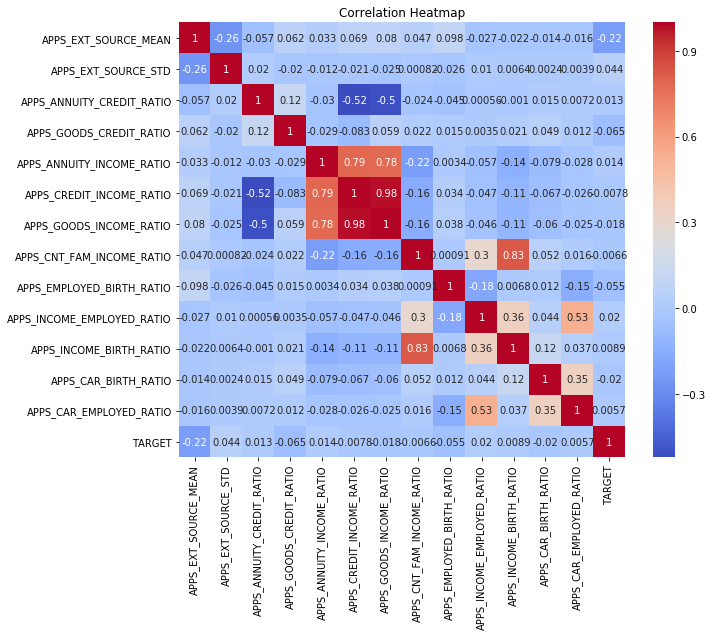

In [34]:
#Correlation of Feature enginered columns with the target
new_columns = [
    'APPS_EXT_SOURCE_MEAN',
    'APPS_EXT_SOURCE_STD',
    'APPS_ANNUITY_CREDIT_RATIO',
    'APPS_GOODS_CREDIT_RATIO',
    'APPS_ANNUITY_INCOME_RATIO',
    'APPS_CREDIT_INCOME_RATIO',
    'APPS_GOODS_INCOME_RATIO',
    'APPS_CNT_FAM_INCOME_RATIO',
    'APPS_EMPLOYED_BIRTH_RATIO',
    'APPS_INCOME_EMPLOYED_RATIO',
    'APPS_INCOME_BIRTH_RATIO',
    'APPS_CAR_BIRTH_RATIO',
    'APPS_CAR_EMPLOYED_RATIO'
]

correlation_matrix = df_encoded_train_unique[new_columns + ['TARGET']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [35]:
#obtaining a balanced dataframe
balanced_df = pd.concat((df_encoded_train_unique[df_encoded_train_unique["TARGET"]==1], \
                        df_encoded_train_unique[df_encoded_train_unique["TARGET"]==0]. 
                        sample(n=int(df_encoded_train_unique[df_encoded_train_unique["TARGET"]==1].shape[0]*(65/35)))))
balanced_df.shape

(70922, 238)

In [36]:
#fixing inifnity values 
columns_with_infinity = balanced_df.columns[~np.isfinite(balanced_df).all()]
print(columns_with_infinity)

Index(['AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LANDAREA_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LANDAREA_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
       'FLOORSMAX_MEDI', 'LANDAREA_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ

In [37]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Assuming balanced_df is the DataFrame containing the data

# Replace infinite values with NaN
balanced_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle missing values by replacing NaN with column medians
imputer = SimpleImputer(strategy='median')
balanced_df = pd.DataFrame(imputer.fit_transform(balanced_df), columns=balanced_df.columns)

In [38]:
#Lightgbm 

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

X_train = balanced_df.drop('TARGET', axis=1)
y_train = balanced_df['TARGET']

# Imputing missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

# Train-Test split
X_train_split, X_test, y_train_split, y_test = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Training the LightGBM model
model = lgb.LGBMClassifier()
model.fit(X_train_split, y_train_split)

# Predict on the test set
test_predictions = model.predict(X_test)

# Calculate the accuracy on the validation set
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test Accuracy:", test_accuracy)

# Handling missing values in the test dataset
X_test_imputed = imputer.transform(df_encoded_test_unique)

# Scaling the features in the test dataset
X_test_scaled = scaler.transform(X_test_imputed)

# Performing prediction on the test dataset
test_predictions = model.predict(X_test_scaled)

output_df = pd.DataFrame({'SK_ID_CURR': df_encoded_test_unique['SK_ID_CURR'], 'TARGET': test_predictions})
output_df.to_csv('gradient_boosting_predictions.csv', index=False)

# Print the DataFrame with predicted values
print(output_df.head())

Test Accuracy: 0.723228762777582
   SK_ID_CURR  TARGET
0      100001     0.0
1      100005     0.0
2      100013     0.0
3      100028     0.0
4      100038     1.0
